In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import clip
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import pickle as pkl
import numpy as np 
import xgboost as xgb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA available: False
CUDA version: None


In [30]:
X_tabular_train = pd.read_csv("../data/preprocessed/train/X_train_tabular_add.csv").astype(np.float32).to_numpy()
y_train = pd.read_csv("../data/preprocessed/train/Y_train.csv").astype(np.float32)
X_images_train = np.array(pkl.load(open("../data/preprocessed/train/train_clip_vectors.pkl", "rb"))).squeeze(1)
X_tabular_test = pd.read_csv("../data/preprocessed/test/X_test_tabular_add.csv").astype(np.float32)
y_test = pd.read_csv("../data/preprocessed/test/Y_test.csv").astype(np.float32)
X_images_test = np.array(pkl.load(open("../data/preprocessed/test/test_clip_vectors.pkl", "rb"))).squeeze(1)

print(X_tabular_train.shape)
print(X_images_train.shape)

X_train = np.concatenate((X_tabular_train, X_images_train), axis=1)
X_test = np.concatenate((X_tabular_test, X_images_test), axis=1)




(18303, 6903)
(18303, 512)


In [10]:
class XgBoost(nn.Module):
    def __init__(self, n_features):
        super(XgBoost, self).__init__()
        self.xgb = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, objective='reg:squarederror')
    
    def forward(self, x):
        return self.xgb.predict(x)
    def fit(self, X, y):
        self.xgb.fit(X, y)
        

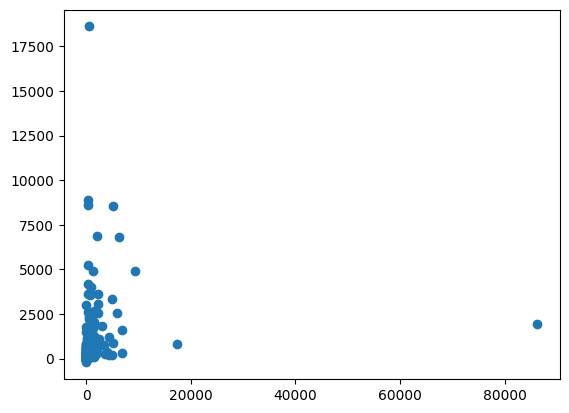

In [31]:
model = XgBoost(n_features=X_tabular_train.shape[1])

model.fit(X_train, y_train)
y_pred = model.forward(X_test)
plt.plot(y_test, y_pred, 'o')